In [2]:
!pip3 install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 56.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 KB 9.0 MB/s eta 0:00:00


In [2]:
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
import sqlite3

from gensim.models.word2vec import PathLineSentences
from gensim.models.callbacks import CallbackAny2Vec

from tqdm import tqdm_notebook as tqdm
import random
from sklearn.metrics import *

In [2]:
class LossLogger(CallbackAny2Vec):
    '''Output loss at each epoch'''

    def __init__(self):
        self.epoch = 1
        self.losses = []

    def on_epoch_begin(self, model):
        print(f'Epoch: {self.epoch}', end='\t', flush=True)

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        print(f'  Loss: {loss}')
        self.epoch += 1


class EpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''
    def __init__(self, path_prefix):
        self.path_prefix = path_prefix
        self.epoch = 0

    def on_epoch_end(self, model):
        output_path = './models/{}_epoch{}.model'.format(self.path_prefix, self.epoch)
        model.save(output_path)

        self.epoch += 1

In [3]:
con = sqlite3.connect('./src/witt.db')

In [4]:
cur = con.cursor()

In [5]:
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category ORDER BY size DESC')

In [6]:
cur.fetchall()

[('software', 4104),
 ('library', 2101),
 ('framework', 1578),
 ('tool', 1288),
 ('null', 1099),
 ('systems', 812),
 ('programming-language', 687),
 ('platform', 646),
 ('company', 634),
 ('language', 587),
 ('class', 478),
 ('service', 449),
 ('plugin', 430),
 ('component', 420),
 ('application', 395),
 ('api', 395),
 ('program', 374),
 ('extension', 349),
 ('functions', 336),
 ('file-format', 318),
 ('os', 314),
 ('method', 313),
 ('engine', 306),
 ('protocols', 293),
 ('server', 285),
 ('ide', 274),
 ('project', 268),
 ('interface', 263),
 ('format', 249),
 ('feature', 231),
 ('web-framework', 226),
 ('standard', 221),
 ('technique', 220),
 ('algorithm', 208),
 ('module', 204),
 ('website', 203),
 ('environment', 198),
 ('utility', 194),
 ('database', 190),
 ('toolkit', 187),
 ('programming', 184),
 ('product', 183),
 ('editor', 173),
 ('technology', 164),
 ('file', 160),
 ('manager', 158),
 ('way', 156),
 ('cms', 156),
 ('solution', 150),
 ('term', 149),
 ('specification', 148),
 (

In [7]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "programming-language"')
results = cur.fetchall()
results

[('javascript',),
 ('java',),
 ('c#',),
 ('php',),
 ('python',),
 ('c++',),
 ('sql',),
 ('objective-c',),
 ('c',),
 ('r',),
 ('ruby',),
 ('swift',),
 ('vb.net',),
 ('vba',),
 ('python-3.x',),
 ('python-2.7',),
 ('scala',),
 ('excel-vba',),
 ('swing',),
 ('linq',),
 ('perl',),
 ('powershell',),
 ('typescript',),
 ('c++11',),
 ('actionscript-3',),
 ('haskell',),
 ('xslt',),
 ('dom',),
 ('assembly',),
 ('c#-4.0',),
 ('awk',),
 ('groovy',),
 ('sed',),
 ('swift3',),
 ('vbscript',),
 ('clojure',),
 ('linq-to-sql',),
 ('lua',),
 ('ecmascript-6',),
 ('java-8',),
 ('coffeescript',),
 ('vb6',),
 ('access-vba',),
 ('actionscript',),
 ('swift2',),
 ('fortran',),
 ('erlang',),
 ('dart',),
 ('qml',),
 ('applescript',),
 ('scheme',),
 ('lisp',),
 ('elixir',),
 ('glsl',),
 ('jstl',),
 ('ocaml',),
 ('linq-to-xml',),
 ('c++14',),
 ('processing',),
 ('shader',),
 ('common-lisp',),
 ('xslt-1.0',),
 ('vhdl',),
 ('racket',),
 ('wolfram-mathematica',),
 ('verilog',),
 ('julia-lang',),
 ('elisp',),
 ('sparql'

In [8]:
results = np.array(results).squeeze()

In [9]:
results

array(['javascript', 'java', 'c#', 'php', 'python', 'c++', 'sql',
       'objective-c', 'c', 'r', 'ruby', 'swift', 'vb.net', 'vba',
       'python-3.x', 'python-2.7', 'scala', 'excel-vba', 'swing', 'linq',
       'perl', 'powershell', 'typescript', 'c++11', 'actionscript-3',
       'haskell', 'xslt', 'dom', 'assembly', 'c#-4.0', 'awk', 'groovy',
       'sed', 'swift3', 'vbscript', 'clojure', 'linq-to-sql', 'lua',
       'ecmascript-6', 'java-8', 'coffeescript', 'vb6', 'access-vba',
       'actionscript', 'swift2', 'fortran', 'erlang', 'dart', 'qml',
       'applescript', 'scheme', 'lisp', 'elixir', 'glsl', 'jstl', 'ocaml',
       'linq-to-xml', 'c++14', 'processing', 'shader', 'common-lisp',
       'xslt-1.0', 'vhdl', 'racket', 'wolfram-mathematica', 'verilog',
       'julia-lang', 'elisp', 'sparql', 'xquery', 'c#-3.0', 'haml',
       'word-vba', 'facebook-fql', 'xslt-2.0', 'cython', 'aop',
       'matlab-figure', 'python-3.5', 'java-7', 'aspectj', 'python-3.4',
       'el', 'plpgsql',

In [10]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "website"')
results2 = cur.fetchall()
results2 = np.array(results2).squeeze()
results2

array(['google-maps', 'amazon-web-services', 'google-maps-api-3',
       'amazon-s3', 'gwt', 'google-analytics', 'youtube', 'google-api',
       'google-drive-sdk', 'gmail', 'google-cloud-platform', 'bitbucket',
       'gitlab', 'google-plus', 'google-cloud-storage', 'prism',
       'openstreetmap', 'google-chrome-app', 'html5-audio', 'blogger',
       'tumblr', 'amazon-cloudfront', 'google-apps', 'jsfiddle',
       'google-maps-api-2', 'google-fusion-tables', 'onedrive', 'vimeo',
       'wiki', 'google-form', 'marker', 'google-translate', 'ebay',
       'forum', 'google-webmaster-tools', 'yahoo-finance', 'bing',
       'yahoo-api', 'reddit', 'zope', 'portal', 'freebase', 'amazon-mws',
       'google-search-api', 'google-apps-marketplace',
       'google-geocoding-api', 'universal-analytics', 'tweets', 'twitch',
       'skin', 'gcp', 'mechanicalturk', 'google-analytics-v4', 'skinning',
       'article', 'imgur', 'hotmail', 'chrome-web-store', 'skydrive',
       'aws-code-deploy', 'goog

In [11]:
x = results.tolist()
y = results2.tolist()
x.extend(y)
_results = x

In [12]:
_results = [x.split('-')[0] for x in _results]

In [13]:
_results

['javascript',
 'java',
 'c#',
 'php',
 'python',
 'c++',
 'sql',
 'objective',
 'c',
 'r',
 'ruby',
 'swift',
 'vb.net',
 'vba',
 'python',
 'python',
 'scala',
 'excel',
 'swing',
 'linq',
 'perl',
 'powershell',
 'typescript',
 'c++11',
 'actionscript',
 'haskell',
 'xslt',
 'dom',
 'assembly',
 'c#',
 'awk',
 'groovy',
 'sed',
 'swift3',
 'vbscript',
 'clojure',
 'linq',
 'lua',
 'ecmascript',
 'java',
 'coffeescript',
 'vb6',
 'access',
 'actionscript',
 'swift2',
 'fortran',
 'erlang',
 'dart',
 'qml',
 'applescript',
 'scheme',
 'lisp',
 'elixir',
 'glsl',
 'jstl',
 'ocaml',
 'linq',
 'c++14',
 'processing',
 'shader',
 'common',
 'xslt',
 'vhdl',
 'racket',
 'wolfram',
 'verilog',
 'julia',
 'elisp',
 'sparql',
 'xquery',
 'c#',
 'haml',
 'word',
 'facebook',
 'xslt',
 'cython',
 'aop',
 'matlab',
 'python',
 'java',
 'aspectj',
 'python',
 'el',
 'plpgsql',
 'netlogo',
 'erb',
 'jpql',
 'outlook',
 'actionscript',
 'vb.net',
 'sympy',
 'python',
 'pascal',
 'swift4',
 'python'

In [14]:
model = Word2Vec.load('./word2vec.w2v')

In [15]:
vectors = []
words = []

for x in _results:
    try:
        vectors.append(model.wv[x])
        words.append(x)
    except:
        print(x)

print(len(vectors), vectors[0].shape)
vectors = np.array(vectors)

typescript2.0
typescript1.8
glsles
rebol3
typescript1.5
fortran2003
typescript1.4
xacml3
typescript1.6
oxygene
typescript1.7
nesc
unrealscript
swift3.2
iolanguage
smallbasic
objectscript
typescript2.2
inform7
swift3.0.2
typescript2.1
linden
xacml2
swift3.1
typescript2.4
freebasic
cobol85
msscriptcontrol
c4.5
fortran2008
dyalog
ironscheme
dom4
perl5.10
c51
ttcn
tla+
pydatalog
c1001
freemat
ada2012
robotc
typescript2.3
gambas
freefem++
ponylang
qore
logiql
oberon
selflanguage
maxmsp
dom3
charm++
hubnet
algol68
ometa
easytrieve
sisc
c4127
macaulay2
bcpl
newspeak
r6025
fstar
rtml
malbolge
bluespec
perl5.18
dom7
ioke
hypertalk
blitzmax
snobol
newtonscript
aimms
jolie
jabaco
c2079
axum
golog
picat
vba7
powerbasic
perl5.16
wollok
vba6
drakon
drakon
swift1
typescript2.6
asml
php4delphi
pogoscript
spiderlang
darkbasic
typescript1.9
ada95
obel
netrexx
pebl
perl5.6
mcpl
mo+
maclisp
yorick
cinnameg
flowcode
interlisp
algoid
mechanicalturk
sinaweibo
zope3
openseamap
buildhive
kiip
identica
idxbroke

In [16]:
tsne = TSNE()
vectors = tsne.fit_transform(vectors)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [17]:
vectors.shape

(768, 2)

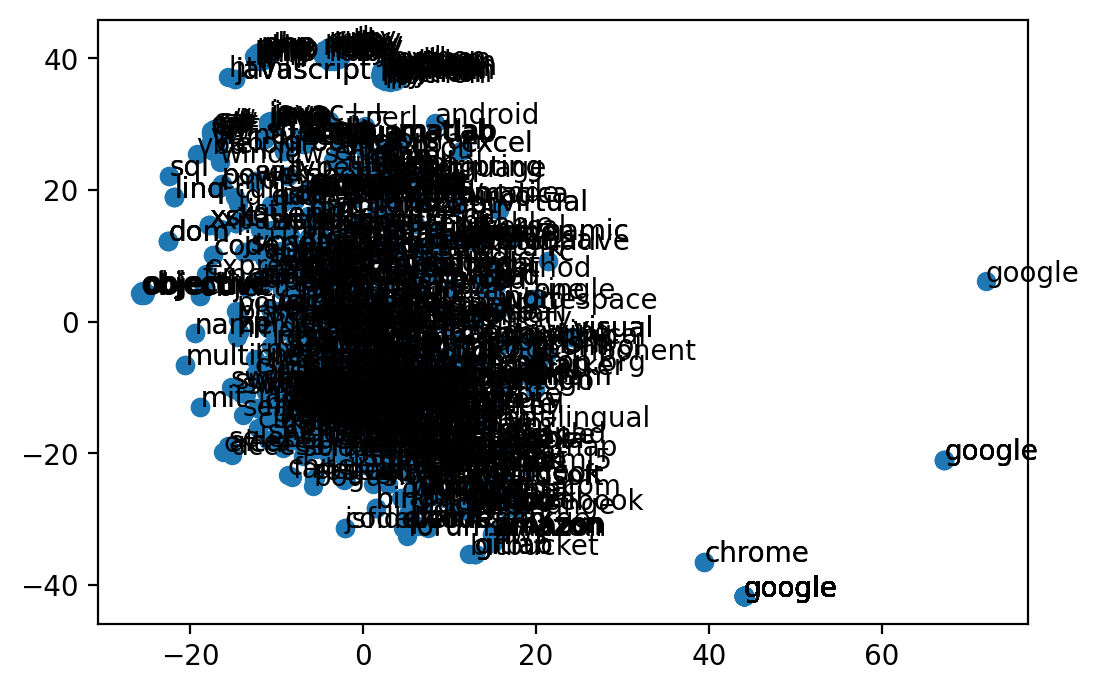

In [18]:
plt.figure(dpi=200)
plt.scatter(vectors.T[0], vectors.T[1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(vectors[i][0], vectors[i][1]))

## Do this with a subset

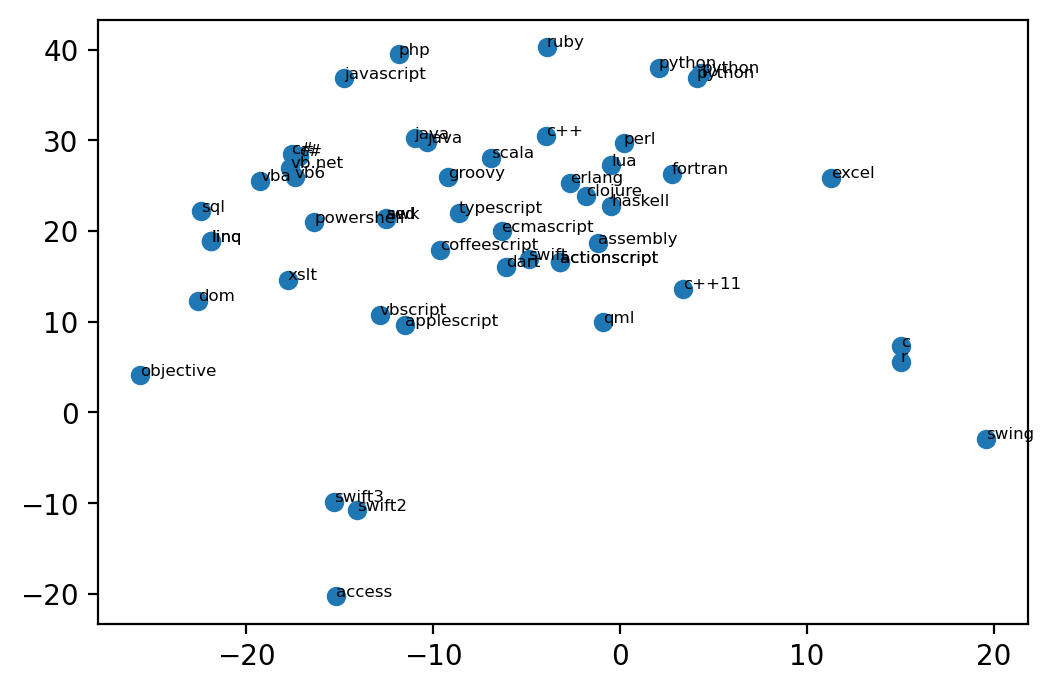

In [19]:
plt.figure(dpi=200)
plt.scatter(vectors[:50].T[0], vectors[:50].T[1])
for i, word in enumerate(words[:50]):
    plt.annotate(word, xy=(vectors[:50][i][0], vectors[:50][i][1]), fontsize=6)

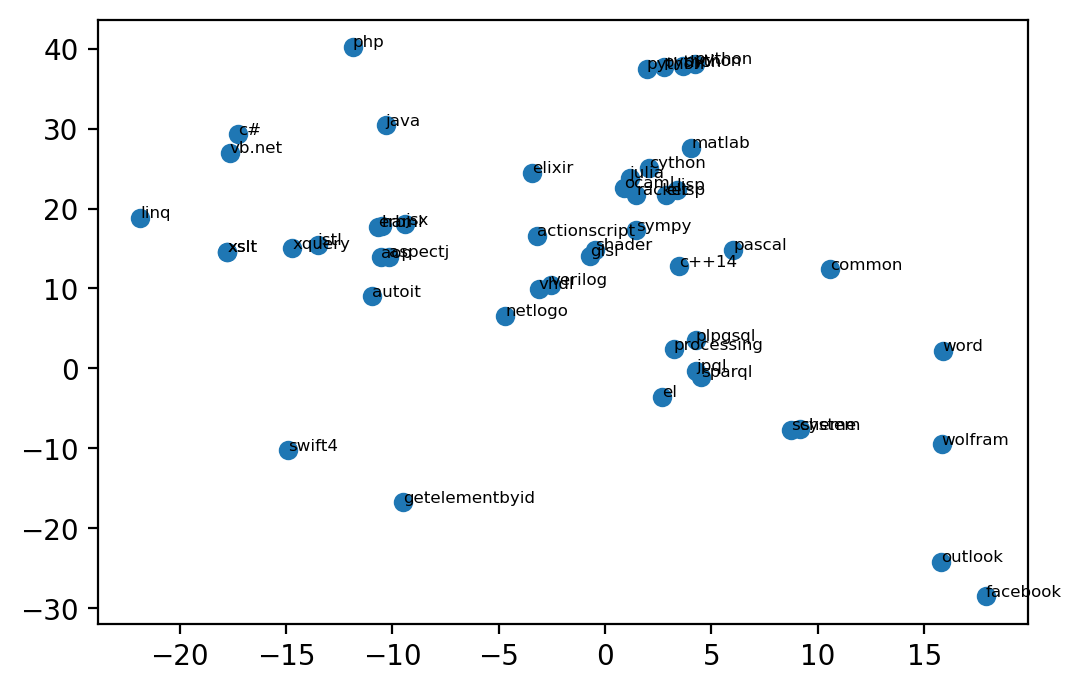

In [20]:
plt.figure(dpi=200)
plt.scatter(vectors[50:100].T[0], vectors[50:100].T[1])
for i, word in enumerate(words[50:100]):
    plt.annotate(word, xy=(vectors[50:100][i][0], vectors[50:100][i][1]), fontsize=6)

## Now embed the same words with a standard model

In [ ]:
standard_model = KeyedVectors.load_word2vec_format('./googlenews/GoogleNews-vectors-negative300.bin', binary=True)

In [167]:
std_vectors = []
words_ = []
indexes = []

for i, x in enumerate(words):
    try:
        std_vectors.append(standard_model[x])
        words_.append(x)
    except KeyError as e:
        indexes.append(i)
        print(x, e)

std_vectors = np.array(std_vectors)
len(std_vectors)

c# "Key 'c#' not present"
c++ "Key 'c++' not present"
vb.net "Key 'vb.net' not present"
vba "Key 'vba' not present"
c++11 "Key 'c++11' not present"
haskell "Key 'haskell' not present"
c# "Key 'c#' not present"
swift3 "Key 'swift3' not present"
vbscript "Key 'vbscript' not present"
clojure "Key 'clojure' not present"
ecmascript "Key 'ecmascript' not present"
coffeescript "Key 'coffeescript' not present"
vb6 "Key 'vb6' not present"
swift2 "Key 'swift2' not present"
fortran "Key 'fortran' not present"
erlang "Key 'erlang' not present"
qml "Key 'qml' not present"
applescript "Key 'applescript' not present"
glsl "Key 'glsl' not present"
jstl "Key 'jstl' not present"
ocaml "Key 'ocaml' not present"
c++14 "Key 'c++14' not present"
vhdl "Key 'vhdl' not present"
verilog "Key 'verilog' not present"
elisp "Key 'elisp' not present"
sparql "Key 'sparql' not present"
xquery "Key 'xquery' not present"
c# "Key 'c#' not present"
haml "Key 'haml' not present"
cython "Key 'cython' not present"
aop "Key '

444

In [169]:
len(words_)

444

In [170]:
tsne = TSNE()
std_vectors = tsne.fit_transform(std_vectors)

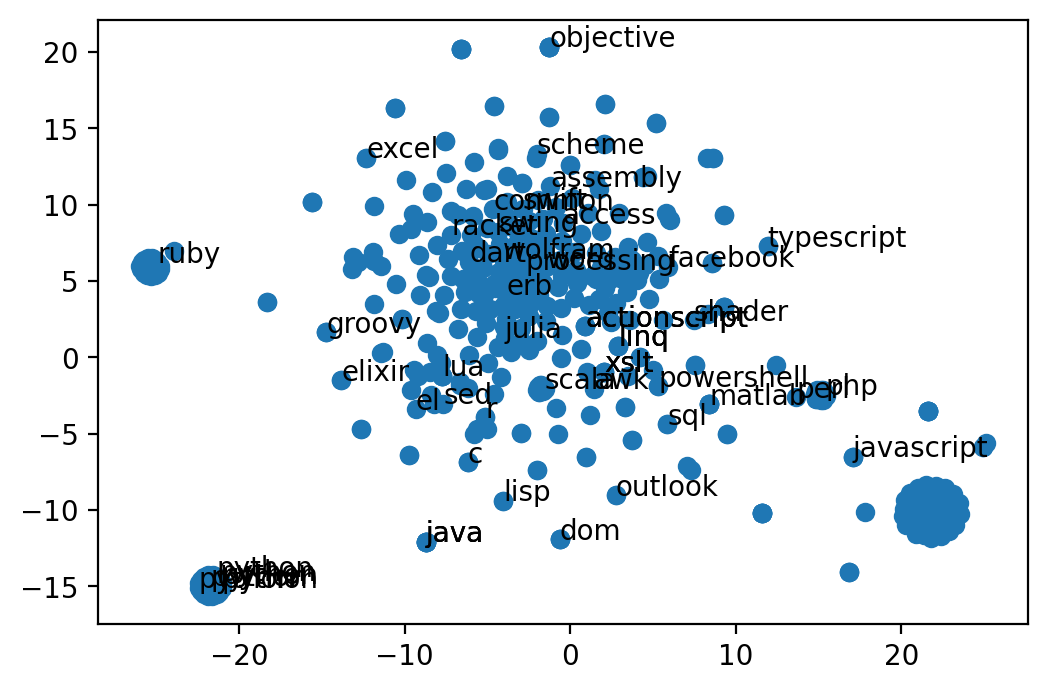

In [172]:
plt.figure(dpi=200)
plt.scatter(std_vectors.T[0], std_vectors.T[1])
for i, word in enumerate(words_[:55]):
    plt.annotate(word, xy=(std_vectors[i][0], std_vectors[i][1]))

## Intrinsic evaluation

In [21]:
cat_to_words = {}

cur = con.cursor()
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category')
categories = cur.fetchall()

for cat, size in categories:
    if size == 0:
        continue
        
    cur = con.cursor()
    cur.execute(f'SELECT Tag FROM Categories WHERE Category = "{cat}"')
    results = cur.fetchall()
    
    if len(results) > 10:
        cat_to_words[cat] = np.array(results).squeeze().tolist()

In [15]:
def embed_words(words: list):
    vectors = []
    w = []

    for x in words:
        try:
            vectors.append(model.wv[x])
            w.append(x)
        except:
            pass

    return np.array(vectors).squeeze(), w

In [24]:
def get_labeled_dataset(vec1: np.ndarray, vec2: np.ndarray):
    return np.concatenate((vec1, vec2)), np.concatenate((np.zeros((len(vec1))), np.ones((len(vec2)))))

In [25]:
def get_dataset_from_multi_vectors(vectors: list):
    X = []
    y = []
    
    c = 0
    for v in vectors:
        X.extend(v)
        y.extend([c] * len(v))
        c += 1
    
    return X, y

In [28]:
bar = tqdm(total=len(cat_to_words))

vectors = []
for cat, words in cat_to_words.items():
    vectors.append(embed_words(words)[0])
    bar.update(1)
            
X, y = get_dataset_from_multi_vectors(vectors)
calinski_harabasz_score(X, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/396 [00:00<?, ?it/s]

4.050232689992554

In [31]:
def intrinsic_eval():
    bar = tqdm(total=100)
    scores = []
    counter = 0
    
    for cat1, words1 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
        for cat2, words2 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
            if cat1 < cat2:
                vec1 = embed_words(words1)[0]
                vec2 = embed_words(words2)[0]

                X, y = get_labeled_dataset(vec1, vec2)
                score = calinski_harabasz_score(X, y)
                scores.append(score)
                counter += 1

                if counter == 100:
                    return scores

                bar.update(1)

In [32]:
intrinsic_eval()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

[1.2211106081574936,
 2.092380131593499,
 2.0164712117359485,
 2.691850064922996,
 2.1154282344156172,
 1.4924852655428054,
 0.9313902002657527,
 2.9002543787362676,
 2.596140270224213,
 1.558337831643355,
 1.4768206471106475,
 1.6881076737190646,
 0.7341849635341042,
 1.3484630378413927,
 1.2434052604130497,
 0.8884766986040354,
 3.23129856884073,
 1.0518532942470804,
 4.056935152672458,
 1.7529380162421038,
 2.189935004329902,
 1.0141847841082905,
 1.3507797269727788,
 6.273778333728038,
 1.427344120668228,
 1.3304295798532026,
 0.28462567167751057,
 1.1592985441895518,
 2.607945419948535,
 1.382457489324557,
 1.6916840357786809,
 1.7512229906160264,
 1.5217959737685633,
 1.1324163220514987,
 1.4764454656947035,
 1.6330456222296184,
 1.3894818215410127,
 1.1541897040034534,
 1.5663925629788864,
 1.4581382099851339,
 3.6225877591302775,
 1.4598279797536955,
 1.825385775375053,
 1.2264998673470735,
 1.817342081208664,
 12.977115613649778,
 1.0783783959591973,
 1.0915850917813137,
 2.97

In [3]:
np.median(_), np.std(_)

(1.588451878851684, 1.6194840261134096)

In [34]:
bert = [1.6341334271092405,
 6.900292395677434,
 1.7204410549851847,
 2.9014840207023167,
 2.566508542143454,
 2.954404144441025,
 2.3664142271656563,
 3.255632143759478,
 3.5050923697882066,
 2.8802397533485347,
 2.4235685304843386,
 1.8282829167800059,
 3.5787418169191194,
 3.3733755348390777,
 2.9303731095172845,
 3.8162473822727203,
 1.6417717152878435,
 2.125341383542855,
 1.6013154388041377,
 2.004054746124951,
 2.4210015596195764,
 2.7711127925562993,
 2.445400828232543,
 5.102734337476773,
 2.2118165112263273,
 3.2620913968873775,
 2.1583956330754503,
 2.2767034254298752,
 2.486810064039823,
 2.153836356370016,
 1.8979570085783615,
 2.4646782289534586,
 1.964526855709898,
 1.366157342689084,
 3.3100673720824565,
 2.828476492181201,
 3.280082132466018,
 1.4638013902392086,
 1.8325971324495238,
 2.5309600769354246,
 1.7151692288678893,
 2.0802118991427783,
 1.7338713350127626,
 4.3752757743326045,
 2.445848796864444,
 2.2602718094596583,
 3.184083708343383,
 2.1208168383515518,
 2.137657661586812,
 1.4907514102089017,
 1.5369876372537317,
 2.3717818097735157,
 1.915271462654402,
 1.9490754531131014,
 4.121238689643424,
 2.252930920572004,
 4.019347649105066,
 2.3737013611760966,
 8.752887044062794,
 2.596864467944543,
 1.917342671100288,
 1.9217560042719024,
 2.618331732655105,
 1.564511466626516,
 1.0898246606326223,
 4.4975822388215825,
 5.638572616775298,
 2.969305317799476,
 2.7893595590675555,
 1.1109561186201444,
 3.962233143730242,
 12.991031115804583,
 3.046179982032098,
 2.183485979543897,
 5.081118415324231,
 2.496043276801091,
 3.7048004085879653,
 2.088306858301775,
 2.152444454932512,
 1.5966151032299223,
 2.5601734473086672,
 2.504214430444843,
 2.00031998175904,
 1.9302344135715517,
 3.0184795646584677,
 2.8641137236004695,
 2.3970359722484393,
 3.68829513365095,
 3.054825523365977,
 1.6153825962259767,
 3.1531729024504993,
 2.2299478583866845,
 1.4039565983294424,
 5.72237123744412,
 3.5507544479990685,
 1.6229058944798507,
 2.501890364630155,
 2.9190478799142507,
 8.175621410789015,
 2.7326194185723276]

In [35]:
w2v = [1.2211106081574936,
 2.092380131593499,
 2.0164712117359485,
 2.691850064922996,
 2.1154282344156172,
 1.4924852655428054,
 0.9313902002657527,
 2.9002543787362676,
 2.596140270224213,
 1.558337831643355,
 1.4768206471106475,
 1.6881076737190646,
 0.7341849635341042,
 1.3484630378413927,
 1.2434052604130497,
 0.8884766986040354,
 3.23129856884073,
 1.0518532942470804,
 4.056935152672458,
 1.7529380162421038,
 2.189935004329902,
 1.0141847841082905,
 1.3507797269727788,
 6.273778333728038,
 1.427344120668228,
 1.3304295798532026,
 0.28462567167751057,
 1.1592985441895518,
 2.607945419948535,
 1.382457489324557,
 1.6916840357786809,
 1.7512229906160264,
 1.5217959737685633,
 1.1324163220514987,
 1.4764454656947035,
 1.6330456222296184,
 1.3894818215410127,
 1.1541897040034534,
 1.5663925629788864,
 1.4581382099851339,
 3.6225877591302775,
 1.4598279797536955,
 1.825385775375053,
 1.2264998673470735,
 1.817342081208664,
 12.977115613649778,
 1.0783783959591973,
 1.0915850917813137,
 2.979517074914314,
 1.1208650763053767,
 0.6588608894465922,
 4.014184282805755,
 3.997726341413953,
 5.250522406587072,
 2.175155424814629,
 1.2576639018500382,
 3.5197565657571683,
 1.0819965944824042,
 0.7280407890555828,
 1.682653310075099,
 2.487991251139136,
 2.6023554863283267,
 1.585627584190655,
 0.5812910743109282,
 0.9070715388799715,
 4.581166554905233,
 0.9330547668092067,
 2.0487297705836305,
 1.2129216619618304,
 1.6027411311087525,
 1.6439319148805729,
 3.1895144766066523,
 1.7640219811069942,
 1.6353794063222489,
 1.706813688321268,
 1.346149525635486,
 2.9567806570679576,
 1.687503149536985,
 1.177731565428825,
 2.4112647750806158,
 4.224928548487471,
 2.548041057626204,
 1.7441431317137008,
 2.5166535097158076,
 1.054774064522935,
 2.1771802985175857,
 0.8761815082947358,
 0.9583763540951639,
 7.907951375097646,
 1.0305563198098346,
 0.8638842678935155,
 2.217531538514899,
 0.7799038426693125,
 1.237328714096383,
 1.0759805207719557,
 1.568009913248692,
 1.846163119790237,
 1.587926507713309,
 1.8514934181250644,
 1.588977249990059]

In [50]:
from scipy.stats import ttest_ind

In [37]:
ttest_ind(bert, w2v)

Ttest_indResult(statistic=3.6404513768053026, pvalue=0.0003473569378476597)

Significant! The two means are different.

## Compare very different topics

In [24]:
def compare_topics(topic1: str, topic2: str):
    cur = con.cursor()
    cur.execute(f'SELECT Tag FROM Categories WHERE Category = "{topic1}"')
    results = cur.fetchall()
    
    v1 = embed_words(results)[0]
    
    cur = con.cursor()
    cur.execute(f'SELECT Tag FROM Categories WHERE Category = "{topic2}"')
    results = cur.fetchall()
    
    v2 = embed_words(results)[0]
        
    y = [0] * len(v1)
    y.extend([1] * len(v2))
    return calinski_harabasz_score(np.concatenate((v1, v2)), y), davies_bouldin_score(np.concatenate((v1, v2)), y)

### These should be different (high CH, low DB)

In [25]:
compare_topics('web-framework', 'machine-learning')

(8.615293426449075, 2.1681576006312318)

In [26]:
compare_topics('data-structure', 'software')

(23.141873615493765, 3.6048550382505766)

In [27]:
compare_topics('software', 'null')

(35.43275272929821, 6.073202717917837)

### These should be same (low CH, high DB)

In [28]:
compare_topics('software', 'product')

(2.263899272289927, 7.625561549354039)

In [29]:
compare_topics('library', 'framework')

(19.913680806833916, 7.1655326653263485)

In [30]:
compare_topics('framework', 'api')

(6.507933244773281, 7.092200212230976)

In [31]:
compare_topics('ide', 'tool')

(4.367869378471332, 5.3876173643645435)

### Compare ratios

In [32]:
def check_ratio(topic1: str, topic2: str, topic3: str):
    """
    Checks the ratio of (topic1, topic2) and (topic1, topic3). topic1 and topic2 should be
    *different*, while topic1 and topic3 should be *similar*.
    
    A good result will have *high* first value and *low* second value.
    """
    ch1, db1 = compare_topics(topic1, topic2)
    ch2, db2 = compare_topics(topic1, topic3)
    
    return ch1 / ch2, db1 / db2

In [33]:
check_ratio('software', 'null', 'product')

(15.651205494429128, 0.7964269488366137)

In [34]:
check_ratio('ide', 'data-structure', 'tool')

(2.781063900041784, 0.5229470733387949)

In [35]:
check_ratio('technique', 'plugin', 'algorithm')

(3.978749044535744, 0.5866633365039067)

In [49]:
check_ratio('technique', 'ide', 'technique')

(5357049192464.04, 1.6379354915706492e-08)

In [52]:
ttest_ind([0.7964, 0.5229, 0.5866], [1.0769, 0.6488, 0.6217], equal_var=True)

Ttest_indResult(statistic=-0.8708179609877108, pvalue=0.432996974099165)

## Can we do arithmetic?

In [47]:
def arithmetic(word1: str, word2: str, word3: str):
    """
    Performs word1 - word2 + word3.
    """
    v = embed_words([word1, word2, word3])[0]
    return v[0] - v[1] + v[2], v[0], euclidean_distances([v[0] - v[1] + v[2]], [v[0]])[0][0]

In [48]:
arithmetic('developer', 'man', 'woman')

(array([ 1.8747886e+00, -4.4045029e+00,  3.4198287e+00, -5.1807895e+00,
        -3.0617073e+00,  3.9131875e+00, -4.7022228e+00,  3.3859897e+00,
         3.1300049e+00,  6.1388521e+00, -3.5276089e+00,  3.6935847e+00,
         4.0051436e+00,  6.8002629e-01,  4.5785408e+00,  3.5279045e+00,
         6.1005850e+00,  6.4775443e-01, -2.4573216e+00,  4.3060040e+00,
         2.0322828e+00, -1.0482476e+00, -4.3257027e+00, -1.8033961e+00,
        -1.8419987e+00, -2.8583505e+00, -6.5846074e-01,  3.5534024e-02,
         4.8754587e+00,  5.3481565e+00, -3.0124941e+00, -1.8828350e+00,
        -7.3521948e+00, -1.7865694e+00, -8.7057710e-02,  2.6609371e+00,
         2.0491290e+00,  6.4307551e+00,  2.1065822e+00,  1.1913335e+01,
        -2.7537684e+00,  3.6165180e+00, -6.5811682e-01,  4.5963316e+00,
        -1.2903581e+00,  4.2769074e+00, -2.8842034e+00,  3.8804646e+00,
         5.1436114e+00, -3.3986669e+00, -3.5895216e-01, -1.4303043e+00,
        -3.4397924e+00,  5.5164394e+00,  3.0473146e+00,  2.75279